### Year Estimates from Wars Discussed in the Speech
One expectation we had for presidential speeches is that a lot of them would discuss or mention wars the United States was fighting at that time. For this reason, we thought that analyzing which wars were discussed in each speech could potentially serve as a useful yardstick for which president was talking. Certainly, some presidents would discuss wars from the past or wars that were also in progress during other president's tenures, but on average we expected that presidents would mostly discuss wars relatively close to the time of their presidency. This notebook creates a function for use later. This function extracts all the wars mentioned in each speech, matches them to a year, averages the years for each speech, and scales the result from 0 to 1.

In [1]:
import pandas as pd
import re # this is for string manipulation and regular expression matching
import numpy as np

#### Pull In Data for Testing
This function will be tested with all of the presidential speeches in our dataset. Therefore, the data is pulled in. Irrelevant columns and rows that are missing a transcript are removed. (Note that this code is commented out so that it is not ran when this notebook is imported in the main notebook. However, for the reader's convenience, images of the results are still displayed in the results section.)

In [2]:
orig_data = pd.read_csv("presidential_speeches.csv")

In [3]:
data = orig_data.drop(columns = ['Date', 'Party', 'Speech Title', 'Summary', 'URL'])

In [4]:
data = data.dropna()

#### List of Wars and Start Dates
This function will require the names of all wars fought by the United States, as well as the date when those wars occurred. Here, this data is extracted from a Wikipedia page.

In [5]:
#read in Wikipedia data
url = 'https://en.wikipedia.org/wiki/List_of_the_lengths_of_United_States_participation_in_wars'
wars = pd.read_html(url, header = 0)

In [6]:
wars = wars[1]

In [7]:
wars = wars.drop(columns = ['Duration (graphical representation)', 'Unnamed: 0'])

In [8]:
wars = wars.dropna()
wars.head()

,War,Dates,Duration
0,Afghan War,"2001 – 2014, 2015 – present[1][2]","19.2 years (19 years, 2 months)"
2,Vietnam War,1955/11 – 1973/04[3][4][5][6][7],"17.4 years (17 years, 4 months)"
4,Moro Rebellion,1899 – 1913,14 years
6,War in North-West Pakistan,2004 – 2017,13 years
8,Northwest Indian War,1785 – 1795,10 years


###### Add a Lowercase Column Containing the Names of Wars, Without the Word "War" at the End.
People are unlikely to always refer to wars by their full name. For instance, when talking about the Vietnam War, people are more inclined to say something like "in Vietnam" instead of "in the Vietnam War." For this reason, the folowing cells extract the shortened name from the list of wars. This introduced the possibility that the function could find times when presidents mention a region or country without talking about the war associated with it. For instance, the president might be talking about Vietnam's economy instead of referencing the Vietnam War, but the function below won't make that distinction. This problem is somewhat mitigated by the fact that public scrutiny of a region or country tends to roughly correspond with any military engagement in the region. (Still, this is a caveat to keep in mind.)

In [9]:
# lowercase and remove "war" from phrase
def remove_war(name):
    if name[-4:len(name)] == ' War':
        return name[0:-4].lower()
    else:
        return name.lower()

In [10]:
# example
remove_war('Afghan War')

'afghan'

In [11]:
# create a new column containing modified names
wars['shortened_name'] = wars['War'].apply(remove_war)
wars.head()

,War,Dates,Duration,shortened_name
0,Afghan War,"2001 – 2014, 2015 – present[1][2]","19.2 years (19 years, 2 months)",afghan
2,Vietnam War,1955/11 – 1973/04[3][4][5][6][7],"17.4 years (17 years, 4 months)",vietnam
4,Moro Rebellion,1899 – 1913,14 years,moro rebellion
6,War in North-West Pakistan,2004 – 2017,13 years,war in north-west pakistan
8,Northwest Indian War,1785 – 1795,10 years,northwest indian


###### Add a Column of the Start Date for Each War
The code below creates a column that contains the years each war started. Perhaps the average of the start and end year would have been slightly better, but that is not the approach taken below. This is because the input data is formatted in a way that would have made this approach very inconvenient.

In [12]:
# Extract year and turn it into an int.
def extract_year(date):
    year = date[0:4]
    return int(year)

In [13]:
wars['year'] = wars['Dates'].apply(extract_year)
wars.head()

,War,Dates,Duration,shortened_name,year
0,Afghan War,"2001 – 2014, 2015 – present[1][2]","19.2 years (19 years, 2 months)",afghan,2001
2,Vietnam War,1955/11 – 1973/04[3][4][5][6][7],"17.4 years (17 years, 4 months)",vietnam,1955
4,Moro Rebellion,1899 – 1913,14 years,moro rebellion,1899
6,War in North-West Pakistan,2004 – 2017,13 years,war in north-west pakistan,2004
8,Northwest Indian War,1785 – 1795,10 years,northwest indian,1785


In [14]:
wars.dtypes

War               object
Dates             object
Duration          object
shortened_name    object
year               int64
dtype: object

###### Create a Regular Expression to Match War Names
Next, a method is needed to search the text for when the presidents mention a war. This is done using regular expressions. The code below creates a regular expression that matches any of the war names. In regular expressions, the "|" symbol means "or." So, the regular expression presented below is looking for something that says "afghan" or "vietnam" or "moro rebellion" and so on.

In [15]:
# this class is used to store the changing verion of the regex string
class rgx():
    def __init__(self):
        self.rgx = ''
    
    def make_regex(self, name):
        self.rgx += name + '|'

In [16]:
# apply the regex creation function, and remove the stray "|" at the very end of the regex string
rgx = rgx()
wars['shortened_name'].apply(rgx.make_regex)
rgx.rgx = rgx.rgx[0:-1]

In [17]:
# The "|" symbol means "or." So, the regular expression is looking for something that says "afghan" or "vietnam" 
# or "moro rebellion" or ...
rgx.rgx

"afghan|vietnam|moro rebellion|war in north-west pakistan|northwest indian|iraq|american revolutionary|second seminole|war on isil|first barbary|american civil|world war ii|korean|war of 1812|red cloud's|mexican–american|world war i|russian civil|great sioux war of 1876|libyan civil war (2011)|persian gulf|whiskey rebellion|spanish–american|kosovo|invasion of panama|cuban missile crisis|invasion of grenada|bay of pigs invasion"

###### Write the Function
Now that the necessary parts have been created, the function itself can be created. The function recieves a dataframe with a column containing transcripts. It finds every mention of a war for every speech, matches the mentions to a date, and returns the average date, scaled.

In [18]:
def year_from_wars(speeches):
    estimates = np.zeros(len(speeches)) # for holding average year
    
    # for every speech
    for idx in range(len(speeches)):
        start_pos = 0
        num_wars = 0
        
        # loop through transcript until every war mention has been found
        while re.search(rgx.rgx, speeches.iloc[idx,:]['Transcript'][start_pos:], re.IGNORECASE) is not None:
            
            found = re.search(rgx.rgx, speeches.iloc[idx,:]['Transcript'][start_pos:], re.IGNORECASE)
            
            # add the date of the beginning of the war
            estimates[idx] += wars[wars['shortened_name'] == speeches.iloc[idx,:]['Transcript'] \
                                   [found.start()+start_pos:found.end()+start_pos].lower()].iloc[0,4]
            
            # the start position for looking at the remaining transcript
            start_pos += found.end()
            
            # tick number of wars found in this speech
            num_wars += 1
        
        # if any wars were found, divide by total number of name drops
        if estimates[idx]: estimates[idx] = estimates[idx]/num_wars
            
    # scale
    estimates = estimates/2019
    
    # return as series WITH NANS
    return pd.Series(estimates, name = 'year_from_wars').replace(to_replace = 0.0, value = np.nan) 
        

###### Test It Out
The function seems to work pretty well. It shows an upward trend in the year estimates, which is expected. It does spit out a lot of NaNs when no wars are mentioned, however. This points in part to linguistic problems; what wars are referred to changes through time.

In [19]:
estimates = year_from_wars(data)

Text(0, 0.5, 'Entry in the Chronological Dataset')

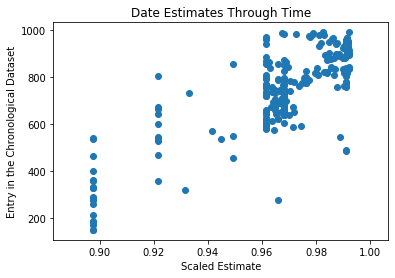

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(estimates, range(len(estimates)))
plt.title("Date Estimates Through Time")
plt.xlabel("Scaled Estimate")
plt.ylabel("Entry in the Chronological Dataset")